In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # 用於統計檢定
import re # 匯入正規表達式模組，用於判斷題幹代碼

# --- 設定字型以正確顯示中文 ---
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 或是 'Noto Sans CJK TC', 'PingFang TC' 等
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題

# --- 載入資料 (欄位名稱已是中文描述) ---
try:
    df_s = pd.read_csv('../data/TIGPSw1_s_descriptive_labeled.csv', low_memory=False)
    print("已成功載入 TIGPSw1_s_descriptive_labeled.csv")
except FileNotFoundError:
    print("錯誤：找不到 TIGPSw1_s_descriptive_labeled.csv，請確認檔案路徑。")
    exit()

# --- 載入 ID 映射檔 (用於查找原始代碼或題幹描述) ---
try:
    with open('../maps/tigps_w1_s_id_map.json', 'r', encoding='utf-8-sig') as f:
        id_map = json.load(f)
    print("已成功載入 tigps_w1_s_id_map.json")
    inverse_id_map = {v: k for k, v in id_map.items()}
except FileNotFoundError:
    print("警告：找不到 tigps_w1_s_id_map.json")
    id_map = {}
    inverse_id_map = {}

# --- 載入 Value 映射檔 (用於定義選項順序或轉換回數值) ---
try:
    with open('../maps/tigps_w1_s_value_maps.json', 'r', encoding='utf-8-sig') as f:
        value_maps = json.load(f)
    print("已成功載入 value_maps")
except FileNotFoundError:
    print("警告：找不到 ../maps/tigps_w1_s_value_maps.json")
    value_maps = {"general_options": {}, "value_maps": {}}

# --- Helper Function: 從 value_maps 獲取選項順序 ---
def get_option_order(original_code):
    return list(value_maps.get('value_maps', {}).get(original_code, {}).values())

# --- Helper Function: 從 value_maps 建立標籤到分數的映射 ---
def get_label_to_score_map(original_code):
    order = get_option_order(original_code)
    return {label: score for score, label in enumerate(order, 1)}


已成功載入 TIGPSw1_s_descriptive_labeled.csv
已成功載入 tigps_w1_s_id_map.json
已成功載入 value_maps


In [ ]:

# ==================================================
# 分析步驟 1: 描述性統計 (使用分組結構)
# ==================================================
print("\n" + "="*30 + "\n 分析步驟 1: 描述性統計 \n" + "="*30)

# 調整後的變項結構：列表的列表
# 每個內部列表第一個元素如果是 's' 開頭加數字，則視為題幹代碼
target_var_groups = [
    # ==================================
    # 目標一：原始核心變項
    # ==================================
    ['as35a'], # 數位學習行為: 上網做功課時間 (獨立項，來源: s35a)
    ['as35b'], # 數位學習行為: 上網課外學習時間 (獨立項，來源: s35b)
    # 數位學習行為: 設備使用頻率 (以 s56 作為題幹，來源: s56)
    # s56 題幹: "請問你使用以下這些設備的頻率如何?"
    ['s56', 'as56a', 'as56b', 'as56d'],
    # 數位學習行為: 線上學習自我管理 (以 s59 作為題幹，來源: s59)
    # s59 題幹: "以下敘述符不符合你的上網學習情形?"
    ['s59', 'as59a', 'as59b', 'as59c', 'as59d'],
    # 數位素養: 數位技能 (以 s60 作為題幹，來源: s60)
    # s60 題幹: "關於電腦與網路的操作,你使用情形如何?"
    ['s60', 'as60a', 'as60b', 'as60c'],
    # 數位素養: 媒體識讀/運用 (以 s61 作為題幹，來源: s61)
    # s61 題幹: "以下關於媒體網站的運用敘述,你同不同意?"
    ['s61', 'as61a', 'as61b', 'as61c', 'as61d', 'as61e', 'as61f', 'as61g', 'as61h', 'as61i'],
    ['as14a'], # 學習動機/興趣 (代理): 喜歡學校程度 (獨立項，來源: s14a)
    ['as19'],  # 學習動機/興趣 (代理): 課業進度感受 (獨立項，來源: s19)
    ['as20'],  # 學業表現: 自評成績等級 (獨立項，來源: s20)

    # ==================================
    # 目標一：建議擴充/脈絡變項
    # ==================================

    # --- 數位學習行為與經驗 (擴充與脈絡) ---
    # 非學習相關的上網時間 (A卷，來源: s35c-f)
    ['s35', 'as35c', 'as35d', 'as35e', 'as35f'], # 將 s35 作為概念上的題組識別
    # 遇到困難時的上網行為 (A卷，以 s37 作為題幹)
    # s37 題幹: "當你在現實生活遇到困難感到憂慮時, 你會上網:"
    ['s37', 'as37a', 'as37b', 'as37c', 'as37d', 'as37e', 'as37f'],
    # 網路使用原因 (A卷，以 s58 作為題幹)
    # s58 題幹: "以下有關使用手機或上網的原因, 你同不同意?"
    ['s58', 'as58a', 'as58b', 'as58c', 'as58d', 'as58e'],
    # 潛在的網路沉迷風險 (以 s41 作為題幹)
    # s41 題幹: "關於上網, 以下敘述符不符合您的情形?"
    ['s41', 'as41a', 'as41b', 'as41c', 'as41d', 'as41e', 'as41f', 'as41g', 'as41h', 'as41i', 'as41j'],

    # --- 數位近用與環境 ---
    # 數位落差/使用障礙 (A卷，以 s57 作為題幹)
    # s57 題幹: "請問你有多常會遇到下面的狀況?"
    ['s57', 'as57a', 'as57b', 'as57c', 'as57d'],
    # 家長對子女上網的管理與態度 (B卷)
    # s28 題幹: "關於上網, 你父親和你有沒有以下的情形?" (as28a-r)
    ['s28', 'as28a', 'as28b', 'as28c', 'as28d', 'as28e', 'as28f', 'as28g', 'as28h', 'as28i', 'as28j', 'as28k', 'as28l', 'as28m', 'as28n', 'as28o', 'as28p', 'as28q', 'as28r'],
    # s29 題幹: "關於上網, 你母親和你有沒有以下的情形?" (as29a-r)
    ['s29', 'as29a', 'as29b', 'as29c', 'as29d', 'as29e', 'as29f', 'as29g', 'as29h', 'as29i', 'as29j', 'as29k', 'as29l', 'as29m', 'as29n', 'as29o', 'as29p', 'as29q', 'as29r'],
    ['as30'], # 主要上網管理者 (獨立項，來源: s30)

    # --- 學習動機/興趣與自我概念 (擴充) ---
    ['as13'], # 學校滿意度 (獨立項，來源: s13)
    # 學校歸屬感/認同感 (以 s14 作為題幹，擴充)
    ['s14', 'as14b', 'as14c'], # as14a 已在核心變項
    # 自我概念/自尊 (以 s65 作為題幹)
    # s65 題幹: "下列是對自己的描述, 你同不同意?"
    ['s65', 'as65a', 'as65b', 'as65c'],
    # 自我效能/決策 (A卷，以 s71 作為題幹)
    # s71 題幹: "以下敘述符不符合你的情形?"
    ['s71', 'as71a', 'as71b', 'as71c', 'as71d', 'as71e', 'as71f'],

    # --- 學業表現與學習相關行為 (脈絡) ---
    ['as22'], # 是否參加校外補習 (獨立項，來源: s22)
    # 校外補習科目 (以 s22a 作為概念上的題組識別)
    ['s22a', 'as22a1', 'as22a2', 'as22a3', 'as22a4', 'as22a5', 'as22a6', 'as22a7'],
    # 時間運用 (A卷，以 s70 作為題幹組)
    # s70 題幹組: "請問在一般要上學的日子裡, 在下列時間中你會做什麼事情?" (涵蓋 as70a - as70p21)
    # **注意**: 這組變項數量龐大(>160個)，分析時需謹慎處理或提取關鍵資訊 (如: 總學習時間、總螢幕時間)
    # 為簡化列表，僅標示代表性題幹 s70，實際使用時需處理 s70a 至 s70p 的所有相關變項
    ['s70'], # 代表 s70a 主/次要活動 至 s70p 主/次要活動 的龐大題組

    # --- 身心健康與社會互動 (潛在影響因素) ---
    # 睡眠習慣與品質 (A卷，以 s68 作為題幹)
    # s68 題幹: "請問你過去一個月來的日常(大多數)睡眠習慣:"
    ['s68', 'as68a1', 'as68a2', 'as68b1', 'as68b2', 'as68c1', 'as68c2', 'as68d1', 'as68d2', 'as68e'],
    # 身心困擾指標 (以 s72 作為題幹)
    # s72 題幹: "請勾選在過去1到2週您感受到下列選項之頻率"
    ['s72', 'as72a', 'as72b', 'as72c', 'as72d', 'as72e', 'as72f', 'as72g', 'as72h', 'as72i', 'as72j', 'as72k', 'as72l'],
    # 遭受實體霸凌經驗 (以 s51 作為題幹)
    # s51 題幹: "上七年級以來, 你曾在實際生活中(非網上), 被其他人辱罵、惡意取笑..."
    # 包含 as51a1-9 (霸凌類型頻率), as51b1-5 (霸凌者), as51c1-12 (反應方式)
    ['s51'], # 代表 s51a, s51b, s51c 的題組
    # 遭受網路霸凌經驗 (以 s53 作為題幹)
    # s53 題幹: "上七年級以來, 你曾在網路上, 被其他人辱罵、惡意取笑..."
    # 包含 as53a1-8 (霸凌類型頻率), as53b1-5 (霸凌者), as53c1-12 (反應方式)
    ['s53'], # 代表 s53a, s53b, s53c 的題組

    # --- 家庭背景 (控制/調節變項，部分範例) ---
    ['as4d1'], # 第一照顧者最高學歷
    ['as4d2'], # 第二照顧者最高學歷 (若有)
    ['as10'],  # 家庭經濟狀況感受
    # 家長參與學校事務 (B卷，以 s24 作為題幹)
    # s24 題幹: "請問以下敘述是否符合你家長的情形?"
    ['s24', 'as24a', 'as24b', 'as24c', 'as24d', 'as24e', 'as24f', 'as24g', 'as24h', 'as24i', 'as24j'],
]

# --- 描述性統計迴圈 (使用分組結構) ---
for group in target_var_groups:
    group_header_printed = False
    stem_code = None
    items_to_analyze = group # 預設分析列表中的所有項目

    # 檢查第一個元素是否可能是題幹代碼 (例如: s56, s59)
    # 這裡用正則表達式判斷是否為 's' 開頭接數字
    if re.match(r'^s\d+$', group[0]):
        stem_code = group[0]
        stem_description = id_map.get(stem_code)
        if stem_description:
            print(f"\n===== 題組: {stem_description} (代碼: {stem_code}) =====")
            group_header_printed = True
            items_to_analyze = group[1:] # 如果有題幹，只分析後面的項目
        else:
            print(f"\n===== 題組 (代碼: {stem_code}，未找到描述) =====")
            group_header_printed = True
            items_to_analyze = group[1:]

    # 遍歷需要分析的項目 (可能是 group[1:] 或整個 group)
    for code in items_to_analyze:
        col_name = id_map.get(code)

        if col_name and col_name in df_s.columns:
            # 如果還沒印過題組標題 (針對獨立項目)，印出分隔線
            if not group_header_printed:
                 print("\n" + "-"*10 + f" 變項: {col_name} (原代碼: {code}) " + "-"*10)
            else:
                 # 如果印過題組標題，印子項目時縮排
                 print(f"\n  --- 子項目: {col_name} (原代碼: {code}) ---")

            # 1. 計算次數分佈
            print("  分佈 (百分比):")
            value_order = get_option_order(code)
            try: # 增加錯誤處理，避免 reindex 時出錯
                if value_order:
                    print(df_s[col_name].value_counts(normalize=True).reindex(value_order).round(3) * 100)
                else:
                    print(df_s[col_name].value_counts(normalize=True).round(3) * 100)
            except KeyError as e:
                 print(f"  警告: 計算分佈時發生索引錯誤: {e}. 可能 value_map 與實際資料不符。顯示原始分佈：")
                 print(df_s[col_name].value_counts(normalize=True).round(3) * 100)


            # 2. 繪製長條圖
            plt.figure(figsize=(10, max(5, len(df_s[col_name].unique()) * 0.5)))
            try: # 增加錯誤處理
                if value_order:
                    valid_order = [v for v in value_order if v in df_s[col_name].unique()]
                    if valid_order:
                         sns.countplot(data=df_s, y=col_name, order=valid_order)
                    else:
                         sns.countplot(data=df_s, y=col_name)
                else:
                    sns.countplot(data=df_s, y=col_name, order = df_s[col_name].value_counts().index)
                plt.title(f"{col_name} 分佈")
                plt.xlabel("人數")
                plt.ylabel("")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"  警告: 繪製圖表時發生錯誤: {e}")
                plt.close() # 關閉可能未完成的圖表

        else:
            print(f"警告：在 id_map 中找不到代碼 '{code}' 或 DataFrame 中不存在欄位 '{col_name}'")


 分析步驟 1: 描述性統計 



 分析步驟 2: 關聯性分析 (執行中...) 

--- 關聯分析: 完成學校功課(查找完成作業需要的資料) (原: as35a) vs 你上學期的平均成績大約如何? (原: as20) ---
交叉表 (行百分比):
你上學期的平均成績大約如何?       全班五名以內  全班六至十名  全班十一至二十名  全班二十一至三十名  全班三十名以後  我不知道
完成學校功課(查找完成作業需要的資料)                                                    
沒有                     20.1    18.4      25.0       18.1      6.4  11.7
0.5小時以內                24.2    22.0      28.6       13.1      4.2   7.6
0.5-1小時                18.6    19.0      31.4       18.4      3.9   8.2
1-1.5小時                16.3    15.0      33.3       21.8      5.5   7.5
1.5-2小時                15.8    12.7      41.5       18.5      5.0   6.2
2-2.5小時                 9.9    17.8      34.7       25.7      5.0   6.9
2.5-3小時                15.6     9.1      40.3       19.5      5.2  10.4
3-3.5小時                 9.7     9.7      45.2        9.7      3.2  22.6
3.5-4小時                28.0    16.0      16.0       16.0     12.0  12.0
4-4.5小時                 0.0    20.0      40.0       20.0     10.0  10.0
4.5-5小時                1

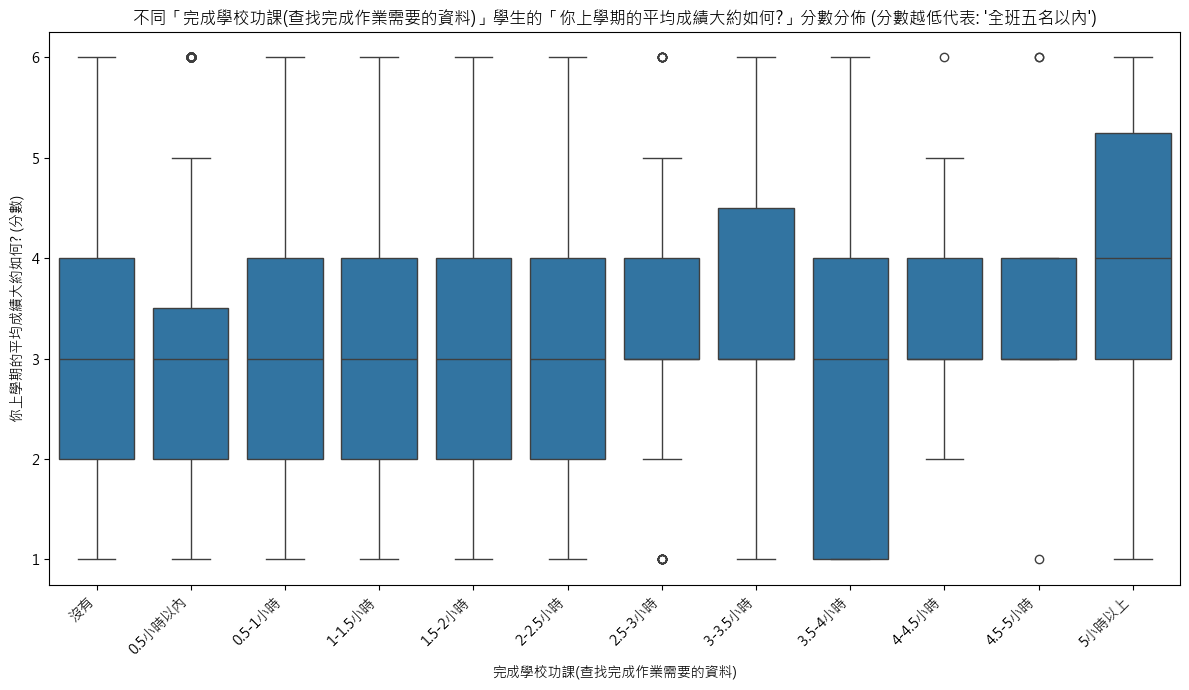

Spearman 相關係數 (完成學校功課(查找完成作業需要的資料) vs 你上學期的平均成績大約如何?): 0.080, p-value: 2.84e-07

--- 關聯分析: 我能判斷適合找到最好答案的關鍵字。 (原: as61a) vs 你上學期的平均成績大約如何? (原: as20) ---
交叉表 (行百分比):
你上學期的平均成績大約如何?     全班五名以內  全班六至十名  全班十一至二十名  全班二十一至三十名  全班三十名以後  我不知道
我能判斷適合找到最好答案的關鍵字。                                                    
很不同意                 14.3    10.7      26.5       23.8      7.3  17.0
不同意                   9.2    10.8      34.5       25.3      8.0  11.6
普通                   12.7    17.7      32.6       18.8      6.1  11.7
同意                   21.5    20.3      31.5       14.9      4.4   7.1
很同意                  26.7    20.2      29.4       13.2      4.3   5.9
不知道                  14.6    15.1      26.7       18.0      6.1  19.6


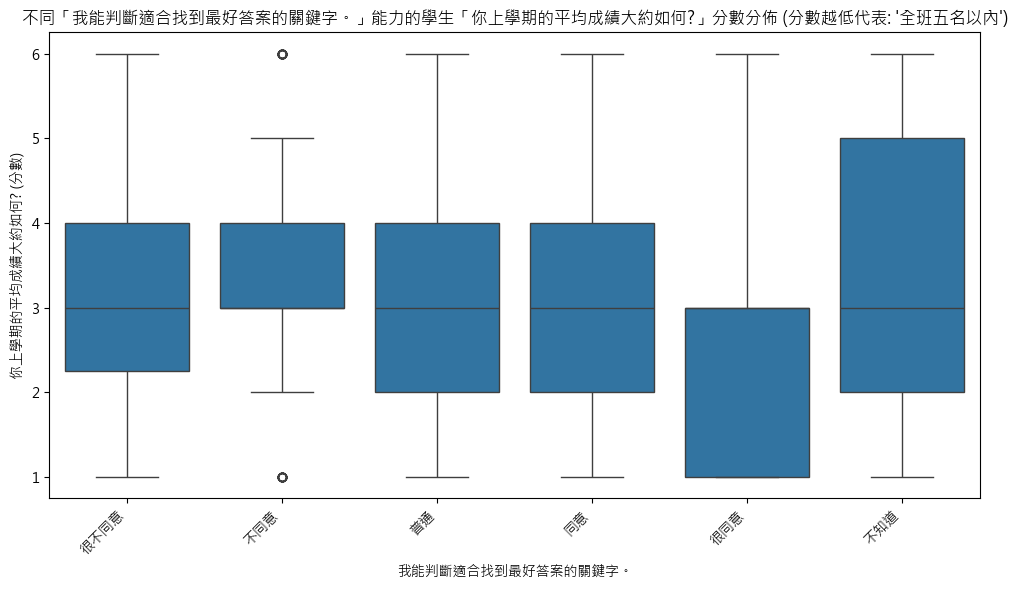

Kruskal-Wallis 檢定 (我能判斷適合找到最好答案的關鍵字。 vs 你上學期的平均成績大約如何?): H=355.668, p-value: 1.05e-74

分析完成。


In [5]:
# ==================================================
# 分析步驟 2: 關聯性分析 (程式碼同前一版本，此處省略以縮短篇幅)
# 只需要確保下面使用的 col_behavior, col_performance, col_literacy 等變數
# 在上面描述性統計部分執行後，DataFrame (df_s) 中已正確創建所需的數值分數欄位 (如 'as20_score')
# ==================================================
print("\n" + "="*30 + "\n 分析步驟 2: 關聯性分析 (執行中...) \n" + "="*30)

# --- 行為 vs 表現: 上網做功課時間 vs 成績 ---
code_behavior = 'as35a'
code_performance = 'as20'
col_behavior = id_map.get(code_behavior)
col_performance = id_map.get(code_performance)
score_col_name = f"{code_performance}_score" # 成績分數欄位名
behavior_score_col = f"{code_behavior}_score" # 行為分數欄位名

if col_behavior and col_performance and col_behavior in df_s.columns and col_performance in df_s.columns:
    print(f"\n--- 關聯分析: {col_behavior} (原: {code_behavior}) vs {col_performance} (原: {code_performance}) ---")
    # 1. 交叉表 (同前)
    # ... (交叉表程式碼) ...
    print("交叉表 (行百分比):")
    order_behavior = get_option_order(code_behavior)
    order_performance = get_option_order(code_performance)
    crosstab_result = pd.crosstab(df_s[col_behavior], df_s[col_performance], normalize='index')
    if order_behavior: crosstab_result = crosstab_result.reindex(order_behavior)
    if order_performance: crosstab_result = crosstab_result.reindex(columns=order_performance)
    print(crosstab_result.round(3) * 100)

    # 2. 視覺化 (Boxplot) - 創建分數欄位
    score_map_performance = get_label_to_score_map(code_performance)
    if score_map_performance:
        df_s[score_col_name] = df_s[col_performance].map(score_map_performance)
        # ... (繪圖程式碼) ...
        plt.figure(figsize=(12, 7))
        valid_order_behavior = [v for v in order_behavior if v in df_s[col_behavior].unique()] if order_behavior else None
        sns.boxplot(data=df_s, x=col_behavior, y=score_col_name, order=valid_order_behavior)
        score_meaning = "(分數越低代表: '{}')".format(get_option_order(code_performance)[0]) if get_option_order(code_performance) else "(分數可能代表選項順序)"
        plt.title(f"不同「{col_behavior}」學生的「{col_performance}」分數分佈 {score_meaning}")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(f"{col_performance} (分數)")
        plt.xlabel(f"{col_behavior}")
        plt.tight_layout()
        plt.show()

        # 3. 統計檢定 (Spearman) - 創建分數欄位
        score_map_behavior = get_label_to_score_map(code_behavior)
        if score_map_behavior:
            df_s[behavior_score_col] = df_s[col_behavior].map(score_map_behavior)
            corr_df = df_s[[behavior_score_col, score_col_name]].dropna()
            if not corr_df.empty:
                 spearman_corr, p_value = stats.spearmanr(corr_df[behavior_score_col], corr_df[score_col_name])
                 print(f"Spearman 相關係數 ({col_behavior} vs {col_performance}): {spearman_corr:.3f}, p-value: {p_value:.3g}")
            else: print("無法計算相關性，因處理遺漏值後無有效數據。")
        else: print(f"無法將 '{col_behavior}' 轉換為分數進行相關性分析。")
    else: print(f"無法將 '{col_performance}' 轉換為分數進行 Boxplot 或相關性分析。")
else: print(f"警告：缺少欄位 '{col_behavior}' 或 '{col_performance}'，無法進行關聯分析。")


# --- 素養 vs 表現: 判斷關鍵字能力 vs 成績 ---
code_literacy = 'as61a'
# code_performance = 'as20' (已定義)
col_literacy = id_map.get(code_literacy)
# col_performance (已定義)

if col_literacy and col_performance and col_literacy in df_s.columns and col_performance in df_s.columns:
    print(f"\n--- 關聯分析: {col_literacy} (原: {code_literacy}) vs {col_performance} (原: {code_performance}) ---")
    # 1. 交叉表 (同前)
    # ... (交叉表程式碼) ...
    print("交叉表 (行百分比):")
    order_literacy = get_option_order(code_literacy)
    crosstab_result_lit = pd.crosstab(df_s[col_literacy], df_s[col_performance], normalize='index')
    if order_literacy: crosstab_result_lit = crosstab_result_lit.reindex(order_literacy)
    if order_performance: crosstab_result_lit = crosstab_result_lit.reindex(columns=order_performance)
    print(crosstab_result_lit.round(3) * 100)

    # 2. 視覺化 (Boxplot)
    if score_col_name in df_s.columns: # 確保分數欄位已創建
         # ... (繪圖程式碼) ...
        plt.figure(figsize=(10, 6))
        valid_order_literacy = [v for v in order_literacy if v in df_s[col_literacy].unique()] if order_literacy else None
        sns.boxplot(data=df_s, x=col_literacy, y=score_col_name, order=valid_order_literacy)
        score_meaning = "(分數越低代表: '{}')".format(get_option_order(code_performance)[0]) if get_option_order(code_performance) else "(分數可能代表選項順序)"
        plt.title(f"不同「{col_literacy}」能力的學生「{col_performance}」分數分佈 {score_meaning}")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(f"{col_performance} (分數)")
        plt.xlabel(f"{col_literacy}")
        plt.tight_layout()
        plt.show()

        # 3. 統計檢定 (Kruskal-Wallis)
        # ... (檢定程式碼) ...
        groups = [df_s[score_col_name][df_s[col_literacy] == group].dropna()
                  for group in (valid_order_literacy if valid_order_literacy else df_s[col_literacy].unique())]
        groups = [g for g in groups if not g.empty]
        if len(groups) > 1:
            try:
                kruskal_stat, p_value_kruskal = stats.kruskal(*groups)
                print(f"Kruskal-Wallis 檢定 ({col_literacy} vs {col_performance}): H={kruskal_stat:.3f}, p-value: {p_value_kruskal:.3g}")
            except ValueError as e: print(f"執行 Kruskal-Wallis 檢定時出錯: {e}")
        else: print("無法執行 Kruskal-Wallis 檢定 (有效組別不足或數據問題)。")
    else: print(f"缺少分數欄位 '{score_col_name}'，無法進行 Boxplot 或統計檢定。")
else: print(f"警告：缺少欄位 '{col_literacy}' 或 '{col_performance}'，無法進行關聯分析。")


print("\n分析完成。")